In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
import xgboost as xgb
import matplotlib
import torch
import torch.utils.data as data_utils
import torch.nn as nn
import tensorflow as tf

In [2]:
date='16Mar2021'
dir_name='/preprocessing/200PU_2806'
workdir=os.getcwd()
files_dir='/data_cms_upgrade/hakimi'
os.makedirs(workdir+dir_name, exist_ok=True)
data_dir=workdir+dir_name
signal='elec'
bkg = 'QCD'

In [3]:
%%time
columns=['genpart_exeta',
         'genpart_pt',
 'cl3d_pt',
 'cl3d_eta',
 'cl3d_showerlength',
 'cl3d_coreshowerlength',
 'cl3d_firstlayer',
 'cl3d_maxlayer',
 'cl3d_seetot',
 'cl3d_seemax',
 'cl3d_spptot',
 'cl3d_sppmax',
 'cl3d_szz',
 'cl3d_srrtot',
 'cl3d_srrmax',
 'cl3d_srrmean',
 'cl3d_emaxe',
 'cl3d_hoe',
 'cl3d_meanz',
 'cl3d_layer10',
 'cl3d_layer50',
 'cl3d_layer90',
 'cl3d_ntc67',
 'cl3d_ntc90',
 'layer',
 'sample',
  'matches',
         
        ]


df_sig= pd.read_csv(data_dir+'/{}.csv'.format(signal), usecols=columns, low_memory=True)
if bkg == 'QCD':
    columns =['event', 'genjet_n', 'genjet_energy', 'genjet_pt', 'genjet_eta',
       'genjet_phi', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta',
       'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer', 'deta', 'dphi',
       'deltar', 'matches',]
elif bkg == 'PU':
    columns = ['event', 'cl3d_pt', 'cl3d_energy', 'cl3d_eta', 'cl3d_phi', 
       'cl3d_showerlength', 'cl3d_coreshowerlength', 'cl3d_firstlayer',
       'cl3d_maxlayer', 'cl3d_seetot', 'cl3d_seemax', 'cl3d_spptot',
       'cl3d_sppmax', 'cl3d_szz', 'cl3d_srrtot', 'cl3d_srrmax', 'cl3d_srrmean',
       'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'layer',]

df_bkg= pd.read_csv(data_dir+'/{}.csv'.format(bkg), usecols=columns, low_memory=True)
df_bkg['sample']=bkg

print('done')

done
CPU times: user 19.8 s, sys: 2.17 s, total: 21.9 s
Wall time: 22 s


In [4]:
"""df['genpart_exeta'][df['sample']=='PU']=0
df['genpart_pt'][df['sample']=='PU']=0
df['matches'][df['sample']=='PU']=0"""

"df['genpart_exeta'][df['sample']=='PU']=0\ndf['genpart_pt'][df['sample']=='PU']=0\ndf['matches'][df['sample']=='PU']=0"

# Config

In [5]:
genptcut=20
cl3dptcut=5
PU_cut = 20
etamin=1.6
etamax=2.9
#bkg='PU' # 'pions' or 'PU'
#feature_set=5 # 1: minimal high level set 2: inclusive high level 3: set2 +layer 4: transverse + layers
#5:all high level for jb 6: set 3 but layer_pt/cl3d_pt
opti=False
res_dir=workdir+'/comparison_21Jun'
os.makedirs(res_dir, exist_ok=True)



In [6]:
%%time
sel = ((np.abs(df_sig['genpart_exeta'])>etamin) & (np.abs(df_sig['genpart_exeta'])<etamax )
       & (df_sig['genpart_pt']>genptcut)&  (df_sig['cl3d_pt']>cl3dptcut) 
       &(np.abs(df_sig['cl3d_eta'])>etamin) & (np.abs(df_sig['cl3d_eta'])<etamax ))
df_sig_cut=df_sig[sel]
df_sig_cut.dropna(inplace=True)
if bkg == 'QCD':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>cl3dptcut))
if bkg == 'pions':
    sel =  ((np.abs(df_bkg['genpart_exeta'])>etamin) & (np.abs(df_bkg['genpart_exeta'])<etamax )
       & (df_bkg['genpart_pt']>genptcut)&  (df_bkg['cl3d_pt']>cl3dptcut) 
       &(np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax ))
if bkg == 'PU':
    sel = ((np.abs(df_bkg['cl3d_eta'])>etamin) & (np.abs(df_bkg['cl3d_eta'])<etamax )&(df_bkg['cl3d_pt']>PU_cut))
df_bkg_cut=df_bkg[sel]
df_bkg_cut.dropna(inplace=True)
df_cut= df_sig_cut.append(df_bkg_cut)

from collections import Counter
count=Counter
count(df_cut['sample'])

algo_cut={}

def tolist(x):
    x.test=x.layer[1:-1].split(',')
    return x.test



#cut on cl3deta
df_cut['abseta']=np.abs(df_cut['cl3d_eta'])
sel=(df_cut['abseta']>etamin) & (df_cut['abseta']<etamax)
df_cut=df_cut[sel]
print('cl3d eta cut:', len(df_cut), len(df_cut[df_cut['sample']=='elec']))
print('PU: ', len(df_cut[df_cut['sample']=='PU']))
#layer_pt preproc
df_cut['layer_pt']=df_cut.apply(tolist, axis=1)
df_cut.drop('layer', axis=1, inplace=True)
print("done")

def layering (x):
    return float(x.layer_pt[n])

##besoin de créer une variable par layer?
algo_layer={}
n_layers=len(df_cut['layer_pt'].iloc[0])
#print(n_layers)
layer_columns=[]

for n in range(n_layers):
    print('layering: {}/{}\r'.format(n+1,n_layers),end='', flush=True)
    df_cut['layer_{}'.format(n)]=df_cut.apply(layering, axis=1)
    layer_columns.append('layer_{}'.format(n))
print("done layering")




/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

cl3d eta cut: 342896 207350
PU:  0
done
done layering36
CPU times: user 4min 27s, sys: 24.3 s, total: 4min 51s
Wall time: 4min 52s


In [7]:
# build new vars

#abseta
#df_cut['abseta']=np.abs(df_cut['cl3d_eta'])

#variance
df_cut['varee']=df_cut['cl3d_seetot']**2
df_cut['varpp']=df_cut['cl3d_spptot']**2
df_cut['varzz']=df_cut['cl3d_szz']**2
df_cut['varrr']=df_cut['cl3d_srrtot']**2

#EoT: pt(Ecal)/pt(Tot)
nLayerEcal= 14
sumE=0

sumT=0
for i in range(n_layers):
    #print('Totlayer_{}'.format(i))
    sumT+=df_cut['layer_{}'.format(i)]
    
    
for i in range(1,nLayerEcal+1):
    #print('Ecal layer_{}'.format(i))
    sumE+=df_cut['layer_{}'.format(i)]
df_cut['EoT']=sumE/sumT

#fraction of pt in first x  layers and last x layers
maxfirst = 5
maxlast=10

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        Sum+=df_cut['layer_{}'.format(i)]
    df_cut['first_{}'.format(n)]= Sum/sumT
    
for n in range(1,maxlast):
    Sum=0
    #print(n, ' layers')
    for i in range(n_layers - n, n_layers):
        #print(n,i)
        Sum+=df_cut['layer_{}'.format(i)]
    #print('last_{}'.format(n), sum/sumT)
    df_cut['last_{}'.format(n)]= Sum/sumT
    
    

for n in range(1,maxfirst+1):
    Sum=0
    for i in range(1,n+1):
        #print('layer_{}'.format(nLayerEcal+i))
        Sum+=df_cut['layer_{}'.format(nLayerEcal+i)]
    df_cut['firstHcal_{}'.format(n)]= Sum/sumT
    
    
# Emaxx : pt in x layers around Elec max layer (5)
maxpos=5

#print('emax_1')
Sum=0
Sum+=df_cut['layer_{}'.format(maxpos)]
df_cut['Emax_1']=Sum/sumT
 
#print('emax_2L')
Sum=0
for i in range(maxpos-1, maxpos+1):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2L']=Sum/sumT
    
#print('emax_2R')
Sum=0
for i in range(maxpos, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_2R']=Sum/sumT
    
#print('emax_3')
Sum=0
for i in range(maxpos-1, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_3']=Sum/sumT
#print('emax_4G')
Sum=0
for i in range(maxpos-2, maxpos+2):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4L']=Sum/sumT
#print('emax_4R')
Sum=0
for i in range(maxpos-1, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_4R']=Sum/sumT
#print('emax_5')
Sum=0
for i in range(maxpos-2, maxpos+3):
    #print(i)
    Sum+=df_cut['layer_{}'.format(i)]
    df_cut['Emax_5']=Sum/sumT
    
    
    
    

In [8]:
%%time
#do bitmaps with group
def ebm0(x):
    ebm=[]
    thr=0
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def ebm1(x):
    ebm=[]
    thr=1
    for i in range(1,nLayerEcal+1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def hbm(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal+1,n_layers):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['ebm0']=df_cut.apply(ebm0, axis=1)
df_cut['ebm1']=df_cut.apply(ebm1, axis=1)
df_cut['hbm']=df_cut.apply(hbm, axis=1)

#do bitmaps with group
def reverse_ebm0(x):
    ebm=[]
    thr=0
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_ebm1(x):
    ebm=[]
    thr=1
    for i in range(nLayerEcal, 0, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
def reverse_hbm(x):
    ebm=[]
    thr=0
    for i in range(n_layers-1,nLayerEcal-1, -1):
        #print(float(x.layer_pt[i])>thr)
        ebm.append(int(float(x.layer_pt[i])>thr)) 
    #print(ebm)
    return(np.array(ebm).dot(2**np.arange(len(ebm))[::-1]))
        
df_cut['reverse_ebm0']=df_cut.apply(reverse_ebm0, axis=1)
df_cut['reverse_ebm1']=df_cut.apply(reverse_ebm1, axis=1)
df_cut['reverse_hbm']=df_cut.apply(reverse_hbm, axis=1)
print('done')

done
CPU times: user 8min 34s, sys: 19.7 s, total: 8min 54s
Wall time: 8min 42s


In [9]:
#chose signal and background
#weight calc

df_cut['signal']= 5
df_cut['weight']=0
df_cut['signal'][df_cut['sample']=='elec']= 1
df_cut['signal'][df_cut['sample']!='elec'] = 0

if bkg == 'pions':

    data=df_cut[df_cut['sample']!='PU']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='pions'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))
elif bkg == 'QCD':
    print('QCD')

    data=df_cut
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='QCD'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event
    #print(ws)
    data['weight'][data['signal']==0]=wb
    #print(np.unique(data['weight']))

    #print(wb)
    data['weight'][data['signal']==1]=ws
    #print(np.unique(data['weight']))
elif bkg == 'PU':
    data=df_cut[df_cut['sample']!='pions']
    tot_event=len(data)
    sig_event=len(data[data['sample']=='elec'])
    bkg_event=len(data[data['sample']=='PU'])
    ws=tot_event/sig_event
    wb=tot_event/bkg_event

    data['weight'][data['signal']==0]=wb
    data['weight'][data['signal']==1]=ws
print('signal weight = {}, bkg weight ={}'.format(ws, wb))

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


QCD
signal weight = 1.6537062937062936, bkg weight =2.5297389816003424


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [10]:

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import pickle
features= data.columns.drop(['signal','weight','cl3d_pt', 'genpart_pt', 'genpart_exeta', 'sample', 'matches', 'layer_pt'])
#pickle.dump(scaler, open(f"{res_dir}/scaler_model.pkl", "wb"))
X_train, X_test, y_train, y_test = train_test_split(data[features], data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']], test_size=0.2,random_state=42)
y= data[['signal','weight','cl3d_eta','cl3d_pt', 'genpart_pt', 'genpart_exeta']]
X=data[features]

In [11]:
balancing='comb'

In [12]:
# list BDTs to compare 
BDT_list={}
"""BDT = {'name' : '',
        'path' : '',
        'features' : "",
            }

"""
BDT_list[0]={'name' : 'baseline',
       'path' : '/res/res_pt20_vs{}_featset2/{}'.format(bkg, balancing),
       'features' :['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']
            }

BDT_list[1]={'name' : 'minimal',
       'path' : '/res/res_pt20_vs{}_featset3/{}'.format(bkg, balancing),
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT', 'cl3d_showerlength','cl3d_coreshowerlength'] #hoe/maxlayer

            }
"""
BDT_list[2]={'name' : 'minimal + EoT',
       'path' : '/res/res_pt20_vsPU_featset10_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'EoT']
            }
BDT_list[3]={'name' : 'minimal + hoe',
       'path' : '/res/res_pt20_vsPU_featset15_unstandardized',
       'features' :['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_hoe']
            }"""


BDT_list[2]={'name' : 'minimal + allnewvars',
       'path' : '/res/res_pt20_vs{}_featset4/{}'.format(bkg, balancing),
       'features' : ['cl3d_meanz','cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer',
                'abseta', 'varee', 'varpp', 'varzz', 'varrr',
                  'EoT', 'first_1', 'first_2',
                'first_3', 'first_4', 'first_5', 'last_1', 'last_2', 'last_3', 'last_4',
                'last_5', 'last_6', 'last_7', 'last_8', 'last_9', 'firstHcal_1', 'firstHcal_2',
                'firstHcal_3', 'firstHcal_4', 'firstHcal_5', 'Emax_1', 'Emax_2L', 'Emax_2R', 'Emax_3',
                'Emax_4L', 'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0', 'reverse_ebm1', 'reverse_hbm']
            }  

BDT_list[3]={'name' : 'minimal + bestnewQCD',
       'path' : '/res/res_pt20_vs{}_featset7/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT','ebm1', 'Emax_4R',
                'reverse_ebm1', 'first_2', 'Emax_2R', 'Emax_5', 
                ]
      }


"""BDT_list[5]={'name' : 'minimal + bestnewPU',
       'path' : '/res/res_pt20_vs{}_featset6/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength', 'EoT',
                'firstHcal_5', 'Emax_4R', 'ebm1', 'Emax_2R', 'firstHcal_1', 'Emax_5']
            }

"""
"""
BDT_list[3]={'name' : 'minimal + bestnewpions',
       'path' : '/res/res_pt20_vs{}_featset5/{}'.format(bkg, balancing),
       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',
                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',
                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']
      }

            """

"\nBDT_list[3]={'name' : 'minimal + bestnewpions',\n       'path' : '/res/res_pt20_vs{}_featset5/{}'.format(bkg, balancing),\n       'features' : ['abseta', 'cl3d_firstlayer', 'varee', 'varpp', 'varzz', 'varrr',\n                 'cl3d_meanz', 'cl3d_showerlength','cl3d_coreshowerlength','EoT',\n                'Emax_5', 'ebm1', 'Emax_4R', 'hbm', 'firstHcal_1', 'reverse_ebm1']\n      }\n\n            "

In [13]:
print('test')

test


balancing=['weights', 'ada', 'comb', 'SMOTE', 'under']
features=['cl3d_showerlength','cl3d_coreshowerlength','cl3d_firstlayer','cl3d_maxlayer','varee', 'varzz',
    'varpp', 'varrr',  'cl3d_emaxe', 'cl3d_hoe', 'cl3d_meanz', 'cl3d_layer10', 'cl3d_layer50',
    'cl3d_layer90', 'cl3d_ntc67', 'cl3d_ntc90', 'abseta']
for i in balancing:
    print(i)
    bdt= '/res/res_pt20_vs{}_featset2/{}/model.model'.format(bkg,i )
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt)
    test=xgb.DMatrix(data=X_test[features], label=y_test['signal'], feature_names=features)
    y_test[i] = booster.predict(test)
    matrix= xgb.DMatrix(data=X[features], label =y['signal'],  feature_names=features)
    y[i] = booster.predict(matrix)
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}

for i in balancing:
    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[i], pos_label=1)
    fpr.sort()
    tpr.sort()
    roc_auc = auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(i)
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(i, roc_auc))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(1e-2, 1e-0)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCall_{}.png'.format(bkg))

In [14]:
bkg

'QCD'

In [15]:

for i in BDT_list:
    print(BDT_list[i]['name'])
    bdt=BDT_list[i]
    booster=xgb.Booster({'nthread' : 4})
    booster.load_model(workdir+bdt['path']+'/model.model')
    test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    y_test[bdt['name']] = booster.predict(test)
    matrix= xgb.DMatrix(data=X[bdt['features']], label =y['signal'],  feature_names=bdt['features'], weight = y['weight'])
    y[bdt['name']] = booster.predict(matrix)
    

    """if "unstandardized" not in BDT_list[i]['path']:
        print("loading scaler")
    #load scaler
        scaler=pickle.load(open( workdir + bdt['path']+ '/scaler_model.pkl', "rb" ) )

        test = xgb.DMatrix(data=scaler.transform(X_test[bdt['features']]),label=y_test['signal'],feature_names=bdt['features'], weight=y_test['weight'])
    else : 
        #print("Unstandardized")
        test=xgb.DMatrix(data=X_test[bdt['features']], label=y_test['signal'], feature_names=bdt['features'], weight = y_test['weight'])
    """
    
    

baseline


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


minimal
minimal + allnewvars
minimal + bestnewQCD


In [16]:
booster.get_dump(with_stats=True)

['0:[EoT<0.92217952] yes=1,no=2,missing=1,gain=163111.734,cover=53053.75\n\t1:[Emax_4R<0.509387434] yes=3,no=4,missing=3,gain=5800.50781,cover=25962\n\t\t3:leaf=-0.193292171,cover=23738.5\n\t\t4:leaf=-0.0242663976,cover=2223.5\n\t2:[varrr<2.05174001e-05] yes=5,no=6,missing=5,gain=12802.1953,cover=27091.75\n\t\t5:leaf=0.187450513,cover=25768\n\t\t6:leaf=-0.130645916,cover=1323.75\n',
 '0:[EoT<0.914469242] yes=1,no=2,missing=1,gain=133279.609,cover=52521.7344\n\t1:[Emax_4R<0.490058064] yes=3,no=4,missing=3,gain=3424.85938,cover=25151.4512\n\t\t3:leaf=-0.178324208,cover=22655.2305\n\t\t4:leaf=-0.0546357892,cover=2496.22095\n\t2:[varrr<2.12370232e-05] yes=5,no=6,missing=5,gain=12757.2188,cover=27370.2832\n\t\t5:leaf=0.168872625,cover=25924.8105\n\t\t6:leaf=-0.135656461,cover=1445.47253\n',
 '0:[EoT<0.920039415] yes=1,no=2,missing=1,gain=110704.578,cover=51371.8125\n\t1:[ebm1<8160] yes=3,no=4,missing=3,gain=4011.01562,cover=25020.2539\n\t\t3:leaf=-0.164612576,cover=22387.7773\n\t\t4:leaf=-0

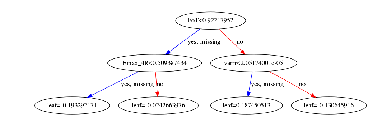

In [17]:
xgb.plot_tree(booster, num_trees = 0)
#plt.rcParams['figure.figsize'] = [600, 300]
#plt.show()

baseline
AUC Score (Test): 99.813962%
minimal
AUC Score (Test): 99.722192%
minimal + allnewvars
AUC Score (Test): 99.868259%
minimal + bestnewQCD
AUC Score (Test): 99.866658%


/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


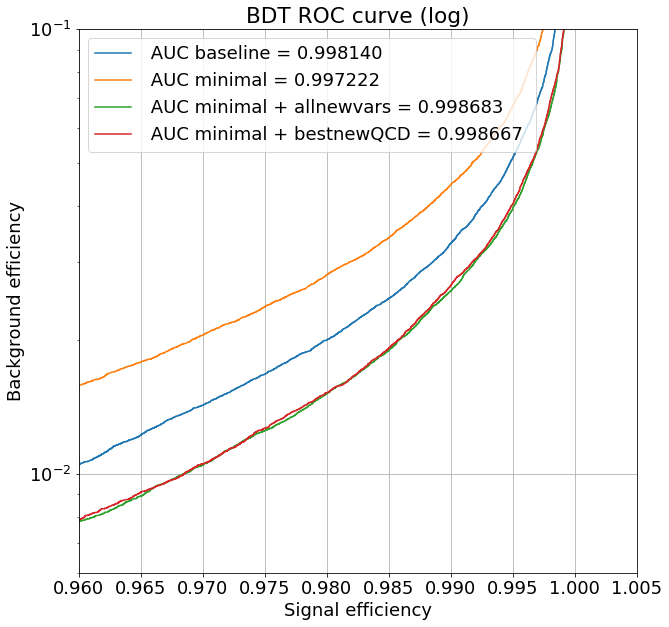

In [18]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[bdt['name']], pos_label=1, sample_weight=y['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc = auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(bdt['name'])
    print ("AUC Score (Test): {:4%}".format(roc_auc))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(6e-3, 1e-1)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend(loc='upper left')
plt.savefig(res_dir+'/ROCall_{}.png'.format(bkg))

baseline
AUC Score (Test): 99.816098%
minimal
AUC Score (Test): 99.718605%
minimal + allnewvars
AUC Score (Test): 99.869204%
minimal + bestnewQCD
AUC Score (Test): 99.867976%


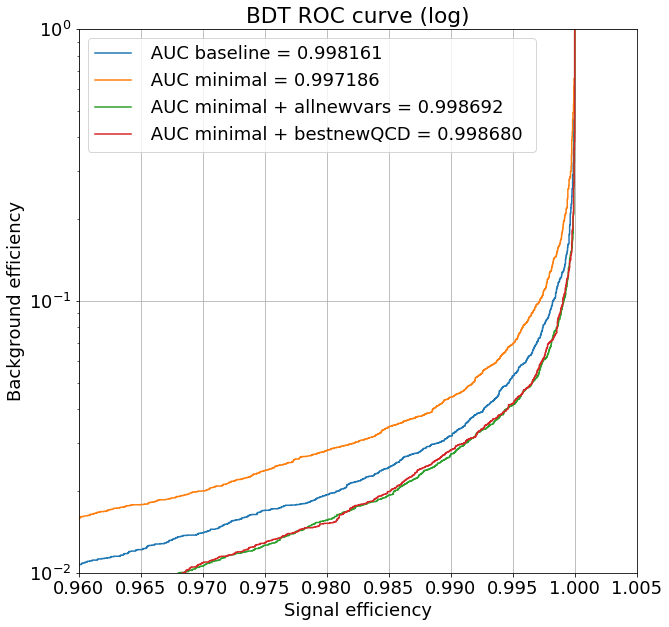

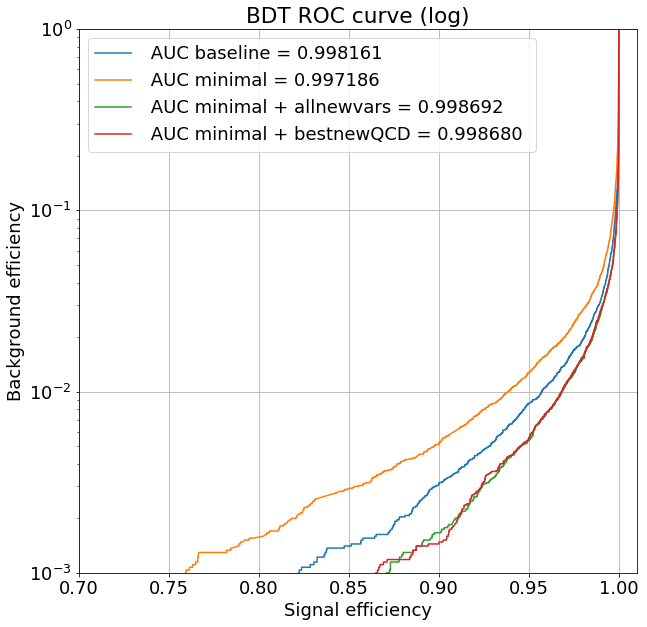

In [19]:
#plot roc curves
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 18}

matplotlib.rc('font', **font)
from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
roc_test={}
roc={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    print(bdt['name'])
    print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.96,1.005)
    plt.ylim(1e-2, 1e-0)
    
 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROCzoom_{}.png'.format(bkg))

plt.figure(figsize=(10,10))
roc_test={}
for i in BDT_list:
    bdt=BDT_list[i]


    fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),y_test[bdt['name']], pos_label=1, sample_weight=y_test['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc_test = auc(fpr, tpr)
    roc_test[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})
    #print(bdt['name'])
    #print ("AUC Score (Test): {:4%}".format(roc_auc_test))
    plt.plot(tpr,fpr, label =' AUC {} = {:0.6f} '.format(bdt['name'], roc_auc_test))
    plt.yscale('log')
    plt.xlim(0.7,1.01)
    plt.ylim(1e-3, 1e-0)
    fpr, tpr, threshold = roc_curve(y['signal'].astype('int32'),y[bdt['name']], pos_label=1, sample_weight=y['weight'])
    fpr.sort()
    tpr.sort()
    roc_auc= auc(fpr, tpr)
    roc[i]= pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})

 
plt.xlabel('Signal efficiency')
plt.ylabel('Background efficiency')
plt.title('BDT ROC curve (log)')
plt.grid()
plt.legend()
plt.savefig(res_dir+'/ROC_{}.png'.format(bkg))

In [20]:
bkg

'QCD'

In [21]:
# calc BDT cut
BDT_cut={}
thr=0.95

for i in BDT_list:
    BDT_cut[i]=np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold'])
    """with open(file_name, 'a') as f:
        f.write('BDT cut ={}  for tpr = {} and fpr {}\n'.format( np.interp(thr,roc_test['tpr'], roc_test['threshold']), np.interp(0.95,roc_test['tpr'], roc_test['tpr']), np.interp(0.95,roc_test['tpr'], roc_test['fpr'])))
"""
    print('BDT cut ={}  for tpr = {} and fpr {}'.format( np.interp(thr,roc_test[i]['tpr'], roc_test[i]['threshold']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['tpr']),
                                                        np.interp(thr,roc_test[i]['tpr'], roc_test[i]['fpr'])))

BDT cut =0.8311562478535621  for tpr = 0.95 and fpr 0.008581785899243811
BDT cut =0.7959822088477493  for tpr = 0.95 and fpr 0.012774654139388145
BDT cut =0.8815092395984825  for tpr = 0.95 and fpr 0.005363616187027384
BDT cut =0.8734560370436308  for tpr = 0.95 and fpr 0.0055115780128764166


In [22]:
#binning y_test


def calctp(group):
    pos=len(group[(group[column]>cutoff) & (group['signal']==1)])
    truepos= len(group[group['signal']==1])
    
    if truepos !=0 :return pos/truepos
    else : return np.nan
def calcfp(group):
    fp = len(group[(group[column]>cutoff) & (group['signal']==0)])
    trueneg = len(group[group['signal']==0])
    if trueneg !=0: return fp/trueneg
    else: return np.nan

In [23]:

#CALCULATE ERROR BARS
conf_level=0.67
from scipy import stats
#normal
#def error(total, score, conf_level):
#    alpha=(1-conf_level)/2
#    sigma=np.sqrt(score*(1-score)/total)
#    delta=np.abs(score-stats.norm.ppf(1-alpha,loc=score, scale=sigma))
#    return delta

#clopper pearson
def error(total, score, conf_level):
    alpha=(1-conf_level)/2
    n=total
    k=score*n
    lo = score-stats.beta.ppf(alpha/2, k, n-k+1)
    hi = stats.beta.ppf(1 - alpha/2, k+1, n-k)-score
    return lo, hi


In [24]:
BDT_list[i]['name']

'minimal + bestnewQCD'

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:873: RuntimeWarning: invalid value encountered in greater
  cond = logical_and(cond, (asarray(arg) > 0))


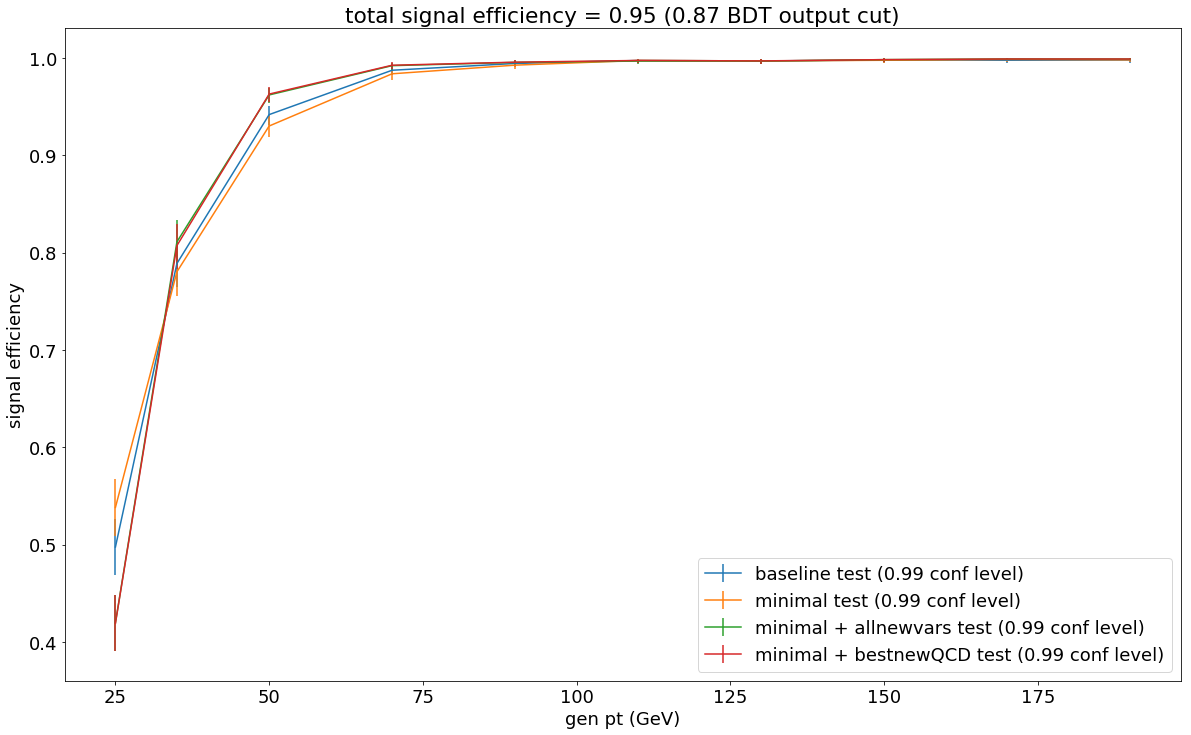

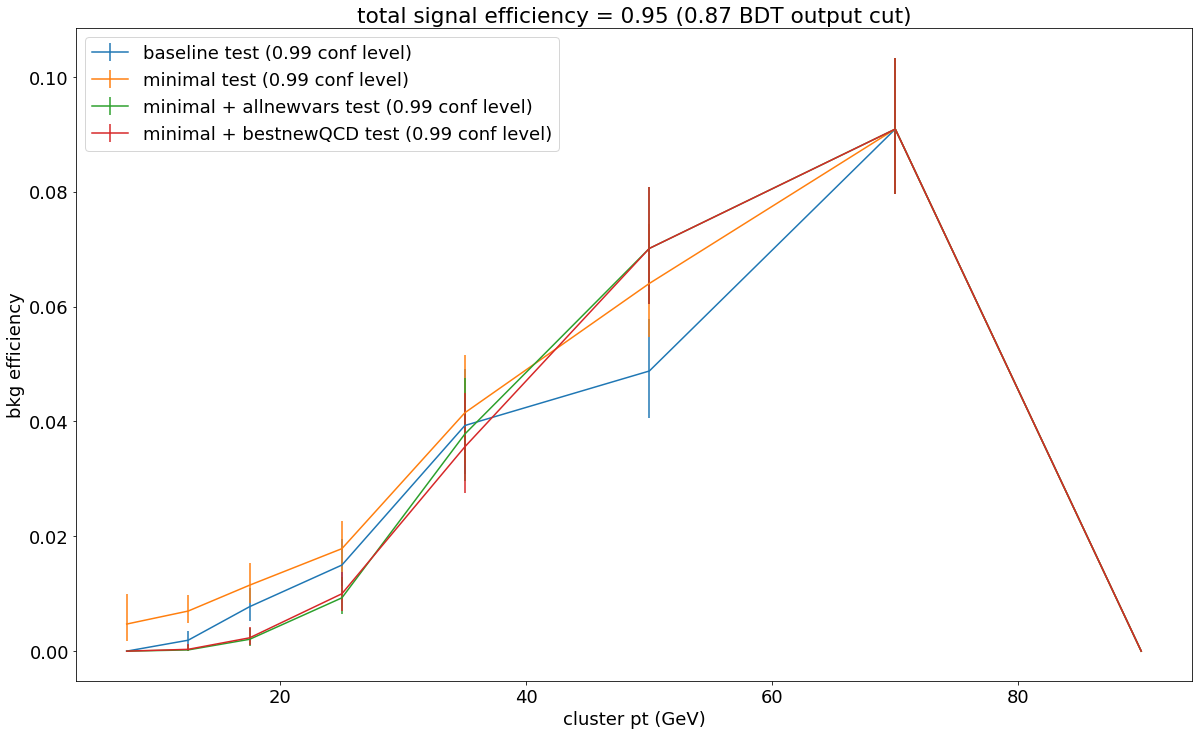

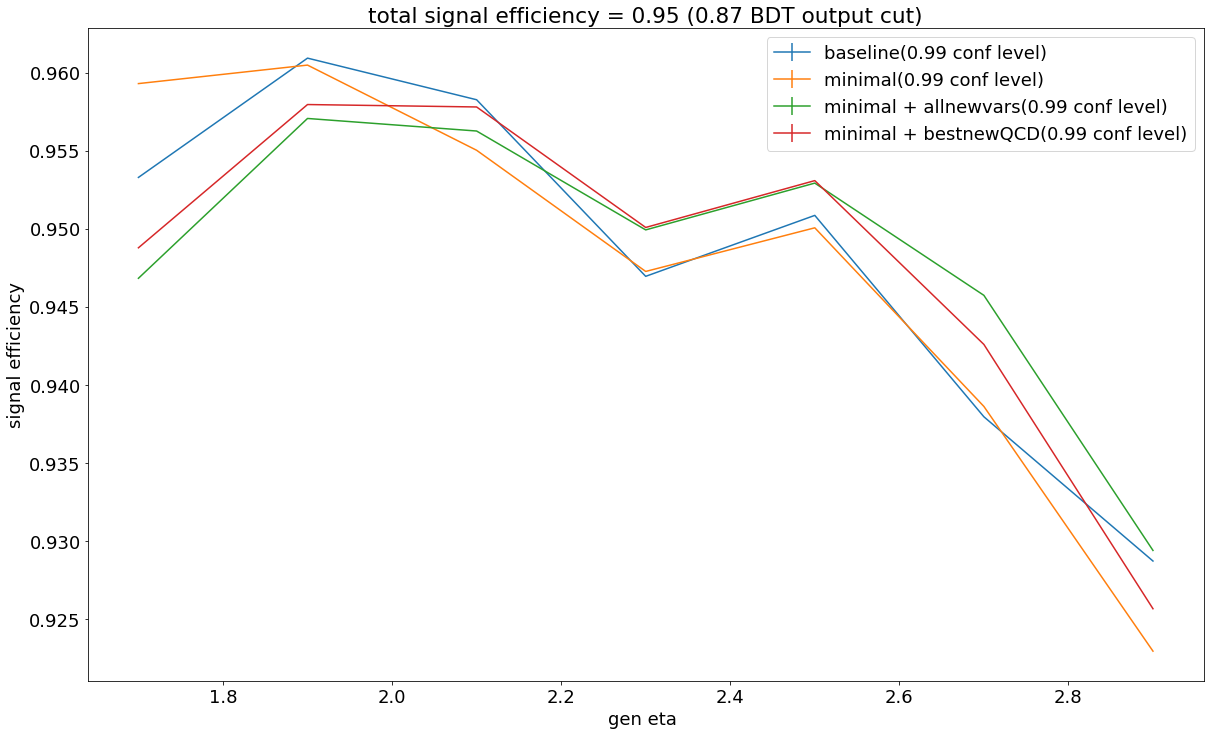

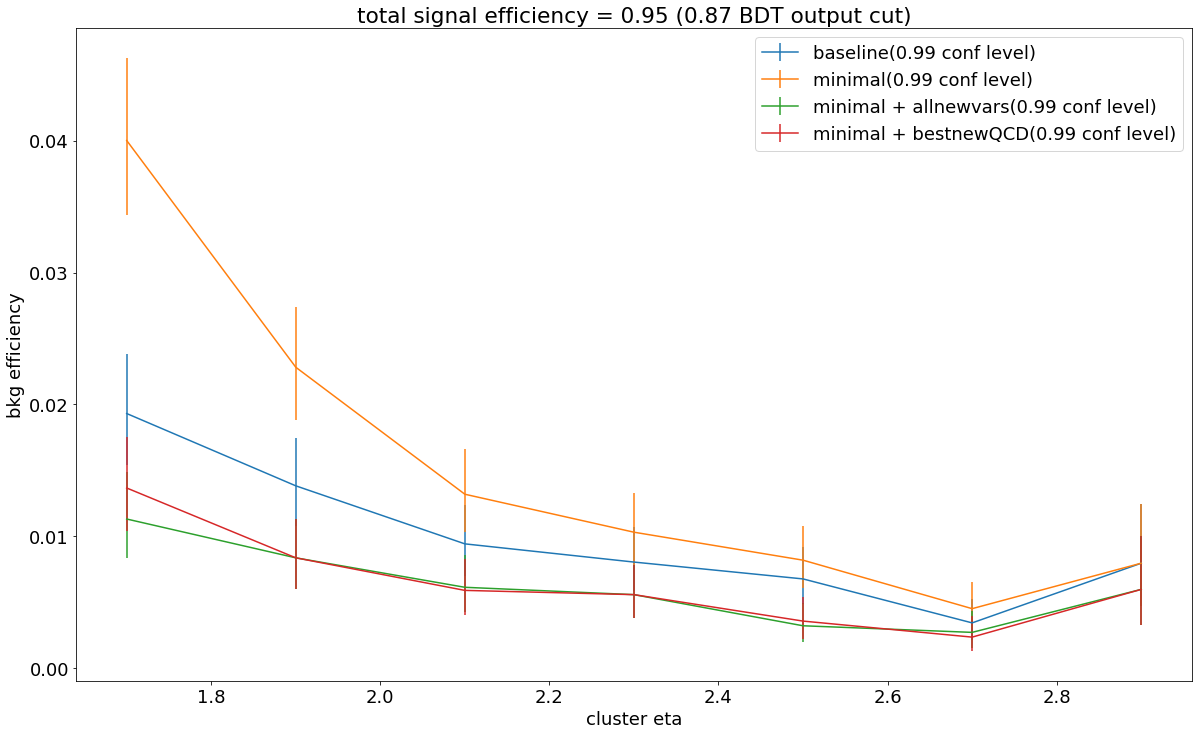

In [25]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut_test={}
y_test['genpt_binned']=pd.cut(y_test['genpart_pt'], pt_bins)
y_test['cl3dpt_binned']=pd.cut(y_test['cl3d_pt'], pt_bins)
y_test['geneta_binned']=pd.cut(np.abs(y_test['genpart_exeta']), eta_bins)
y_test['cl3deta_binned']=pd.cut(np.abs(y_test['cl3d_eta']), eta_bins)

y_train['genpt_binned']=pd.cut(y_train['genpart_pt'], pt_bins)
y_train['cl3dpt_binned']=pd.cut(y_train['cl3d_pt'], pt_bins)
y_train['geneta_binned']=pd.cut(np.abs(y_train['genpart_exeta']), eta_bins)
y_train['cl3deta_binned']=pd.cut(np.abs(y_train['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut_test[i]=roc_test[i][roc_test[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column,conf_level))
"""    
    group=y_train.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column,conf_level))
    """
plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} test ({} conf level)'.format(column, conf_level))
"""   
    group=y_train.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_train.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} train ({} conf level)'.format(column, conf_level))
    """
plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y_test.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y_test.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


In [26]:
bkg

'QCD'

/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/exp_soft/llr/python/3.7.0/el7/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

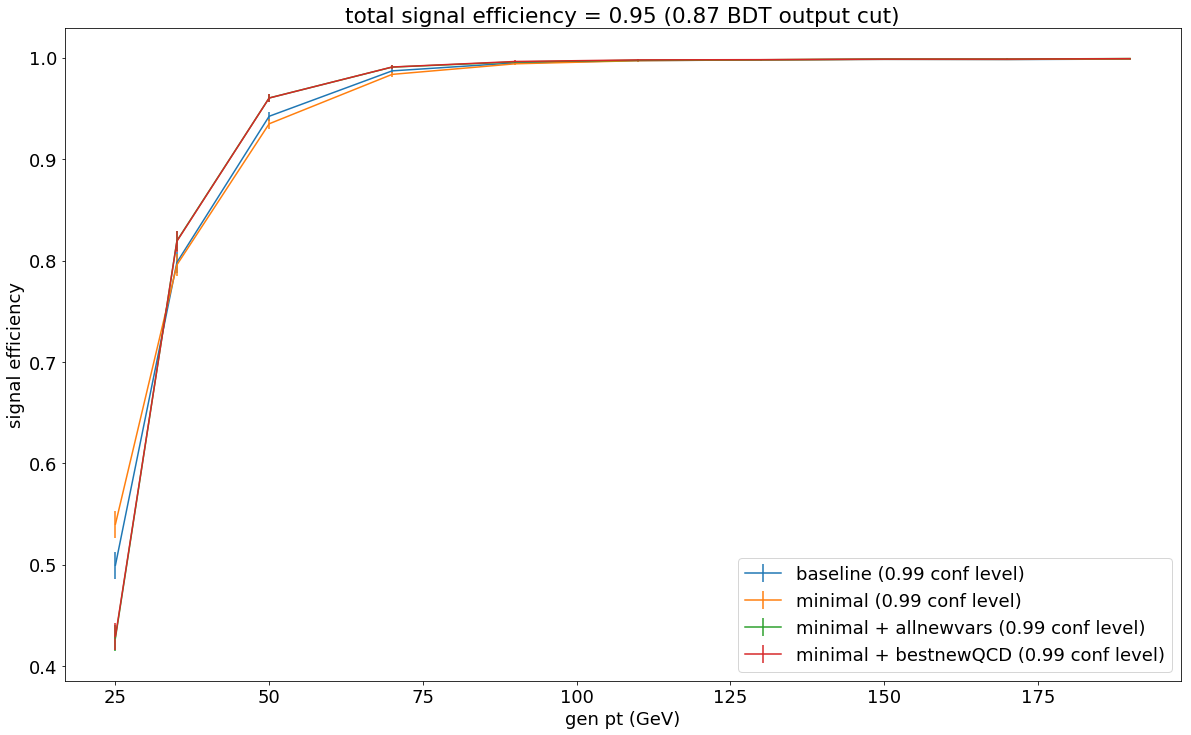

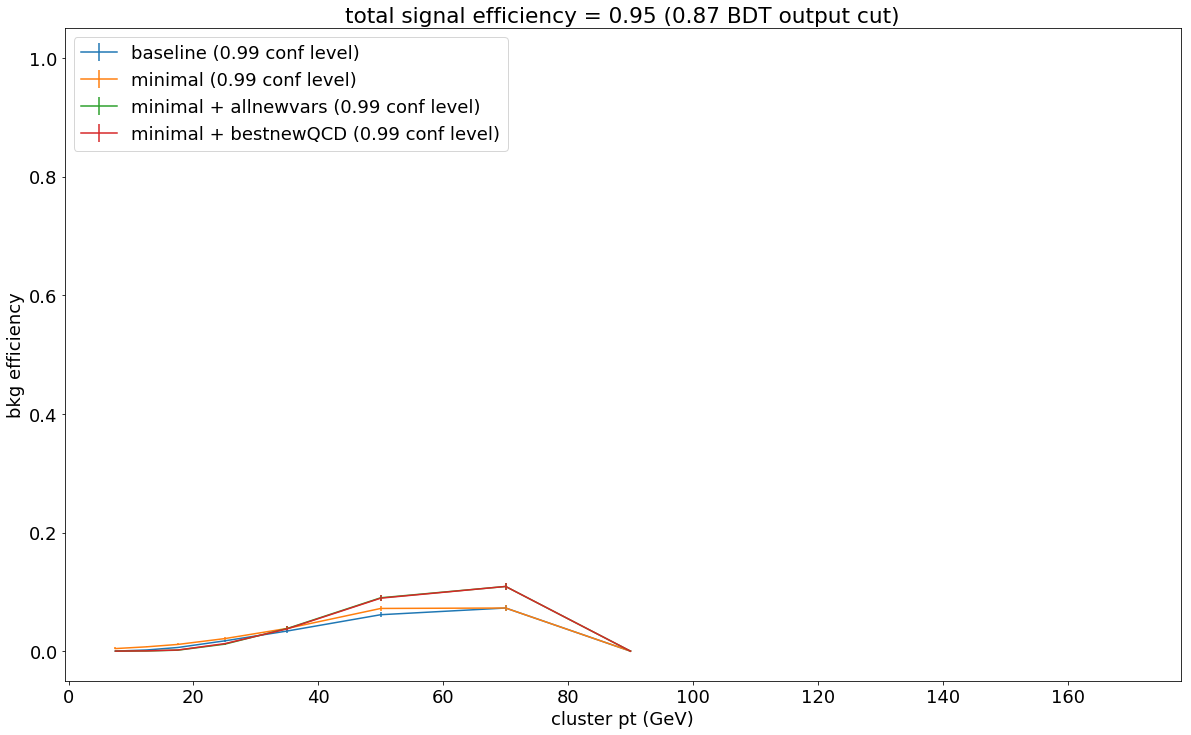

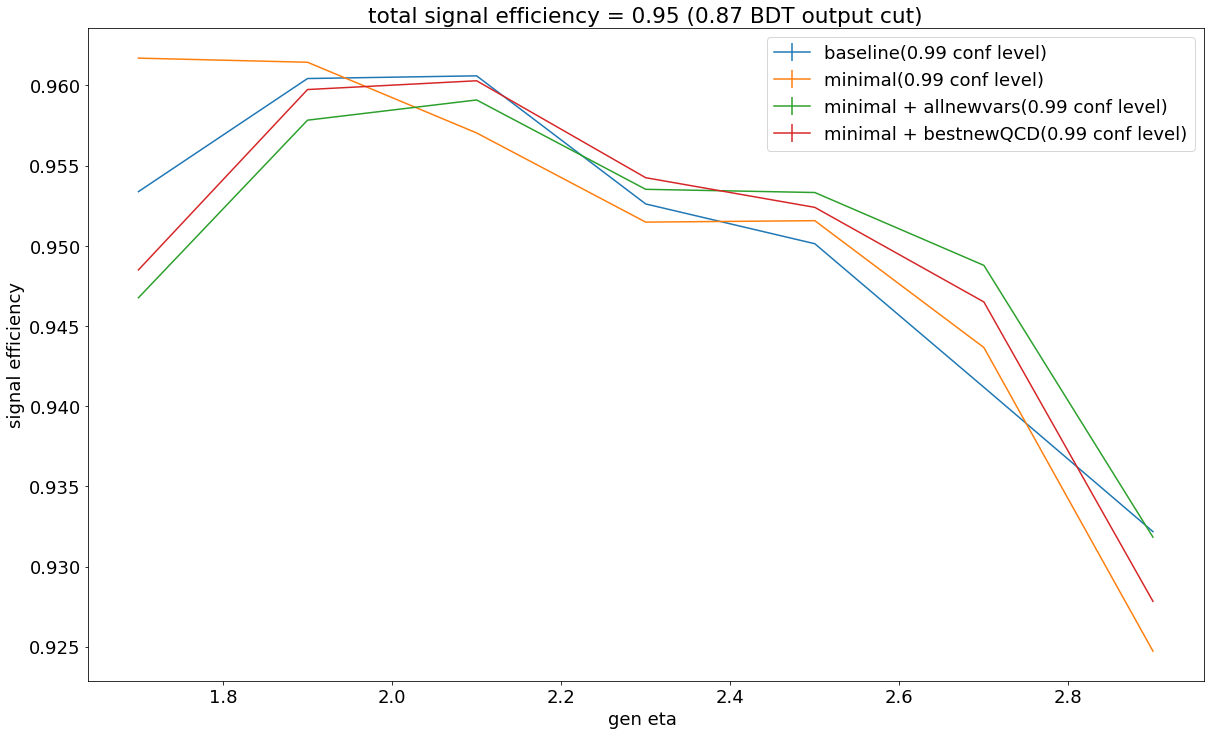

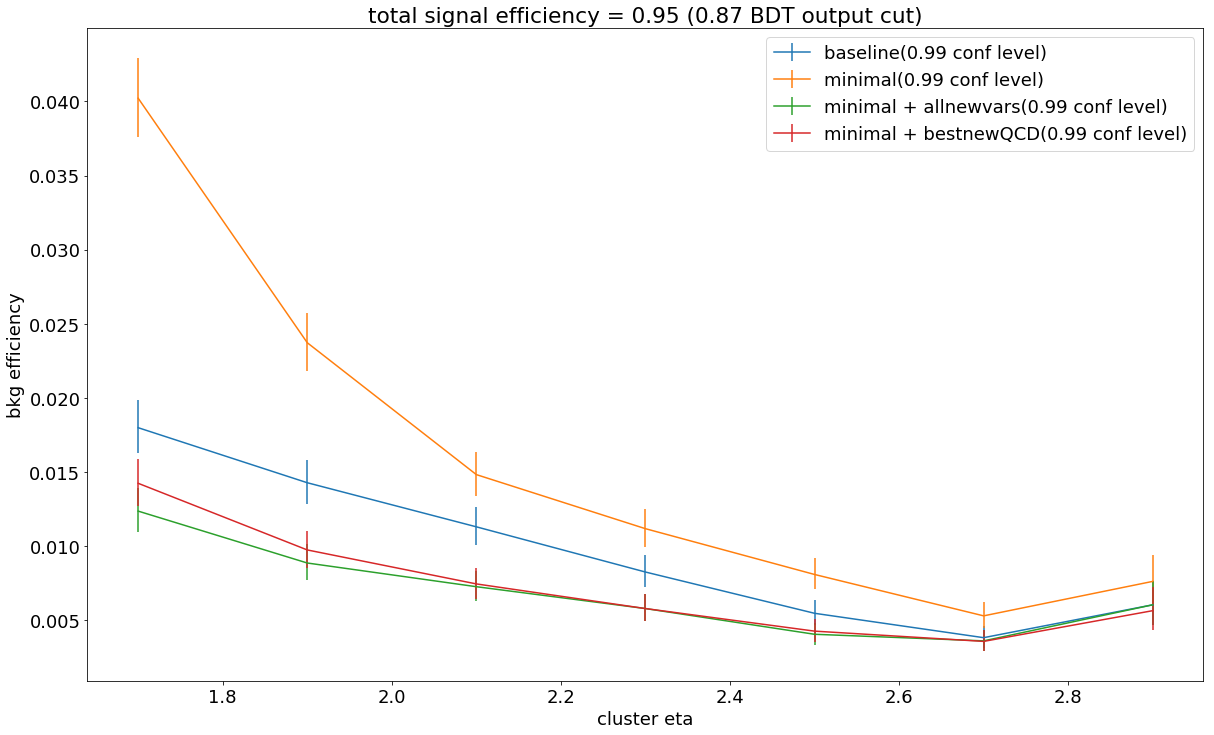

In [27]:
pt_bins=[0,5,10,15,20,30,40,60,80,100,120,140,160,180,200,220]
eta_bins=[1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0]
pt_points=[2.5,7.5,12.5,17.5,25,35,50,70,90,110,130,150,170,190,210]
eta_points=[1.7,1.9,2.1,2.3,2.5,2.7,2.9]
#y_test['BDT']=predictions_BDT_test

"""from sklearn.metrics import roc_curve, auc
plt.figure(figsize=(10,10))
fpr, tpr, threshold = roc_curve(y_test['signal'].astype('int32'),predictions_BDT_test, pos_label=1,  sample_weight=y_test['weight'])
fpr.sort()
tpr.sort()
roc_auc_test = auc(fpr, tpr)
roc_test=pd.DataFrame({'tpr':tpr,'fpr':fpr, 'threshold':threshold})"""

roc_cut={}
y['genpt_binned']=pd.cut(y['genpart_pt'], pt_bins)
y['cl3dpt_binned']=pd.cut(y['cl3d_pt'], pt_bins)
y['geneta_binned']=pd.cut(np.abs(y['genpart_exeta']), eta_bins)
y['cl3deta_binned']=pd.cut(np.abs(y['cl3d_eta']), eta_bins)


plt.figure(figsize=(20,12))
for i in BDT_list:
    roc_cut[i]=roc[i][roc[i]['tpr']>thr];

    conf_level=0.99

    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('genpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('genpt_binned').size(), tpr, conf_level)
    plt.errorbar(pt_points, tpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column,conf_level))

plt.ylabel('signal efficiency')
plt.xlabel('gen pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvspt_WP{}_{}.png'.format(thr, bkg))
    
plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3dpt_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3dpt_binned').size(), fpr, conf_level)
    plt.errorbar(pt_points, fpr.values, yerr=[lo,hi], label ='{} ({} conf level)'.format(column, conf_level))

plt.ylabel('bkg efficiency')
plt.xlabel('cluster pt (GeV)')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvspt_WP{}_{}.png'.format(thr, bkg))


plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('geneta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('geneta_binned').size(), fpr, conf_level)

    plt.errorbar(eta_points, tpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column,conf_level))
plt.ylabel('signal efficiency')
plt.xlabel('gen eta ')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/sigeffvseta_WP{}_{}.png'.format(thr, bkg))

plt.figure(figsize=(20,12))
for i in BDT_list:
    column = BDT_list[i]['name']
    cutoff= BDT_cut[i]
    group=y.groupby('cl3deta_binned')
    tpr = group.apply(calctp)
    fpr= group.apply(calcfp)
    lo,hi=lo,hi=error(y.groupby('cl3deta_binned').size(), fpr, conf_level)
    plt.errorbar(eta_points, fpr.values, yerr=[lo,hi], label ='{}({} conf level)'.format(column, conf_level))
plt.ylabel('bkg efficiency')
plt.xlabel('cluster eta')
plt.title('total signal efficiency = {} ({:0.2f} BDT output cut)'.format(thr, BDT_cut[i]))
plt.legend(loc='best')
plt.savefig(res_dir+'/bkgeffvseta_WP{}_{}.png'.format(thr, bkg))


In [28]:
y_test.groupby('cl3dpt_binned').size()

cl3dpt_binned
(0, 5]           0
(5, 10]       2554
(10, 15]      9517
(15, 20]      7977
(20, 30]      7230
(30, 40]      3675
(40, 60]      5035
(60, 80]      4714
(80, 100]     4701
(100, 120]    4621
(120, 140]    4568
(140, 160]    4624
(160, 180]    4464
(180, 200]    4011
(200, 220]     881
dtype: int64

#res pion BDT
AUC Score (Test): 99.770155%
AUC Score (Train): 99.903230%
background rejection test = 0.9882920110192837, train = 0.994824909435915
#res PU BDT
AUC Score (Test): 99.901765%
AUC Score (Train): 99.914897%
background rejection test = 0.9994748699879739, train = 0.9995563555778215

In [29]:
df_cut.columns

Index(['cl3d_coreshowerlength', 'cl3d_emaxe', 'cl3d_energy', 'cl3d_eta',
       'cl3d_firstlayer', 'cl3d_hoe', 'cl3d_layer10', 'cl3d_layer50',
       'cl3d_layer90', 'cl3d_maxlayer',
       ...
       'Emax_4R', 'Emax_5', 'ebm0', 'ebm1', 'hbm', 'reverse_ebm0',
       'reverse_ebm1', 'reverse_hbm', 'signal', 'weight'],
      dtype='object', length=114)